# SIFT based Image Stitching
    
Welcome to PA5, in this week we will be studying how to stich multiple images to form a panoramic image. In particular, we will use two images coming from the same scene and will match them by using SIFT features in this assignment in four steps:

-  Step 1: First detect keypoints (DoG, Harris, etc.) and extract local invariant descriptors (SIFT, SURF, etc.) from the two input images. We will use features computed by the DoG approach (as they are computed in SIFT).
-  Step 2: Then, we will match the computed keypoints between the two images. We will use David Lowe's technique to match the features.
-  Step 3: To project one image onto another, we will compute (estimate) the homography matrix. For computing the H matrix, we will use the RANSAC algorithm on our matched feature vectors.
-  Step 4: Apply a warping transformation using the H matrix obtained in Step 3 to combine both images.

In this assignment you'll use OpenCV, an essential library for many computer vision applications in Python.

## Prerequisite Packages

You may need to install the OpenCV with the following commands

    pip install opencv-python==3.4.2.16
    pip install opencv-contrib-python==3.4.2.16
    pip install imutils

In [ ]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install imutils

In [ ]:
# import the necessary packages
import numpy as np
import imutils
import cv2

%matplotlib inline

import matplotlib.pyplot as plt

## Introduction

First, lets have a look at two images that we will use in this assignment:
    

Image 1 | Image 2
:------------------------:|:-----------------------:
<img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/bryce_left_02.png?raw=1" style="width:200px;height:150px;">  |  <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/bryce_right_02.png?raw=1" style="width:200px;height:150px;">

The final result should look like this image:

Panorama |
:------------------------:|
<img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/result.png?raw=1" style="width:350px;height:150px;"> |

### Topics Covered
Lets first visualize those images on our own system with the following code:

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Original image dimension: (750, 1000, 3)
Resized image dimension: (300, 400, 3)


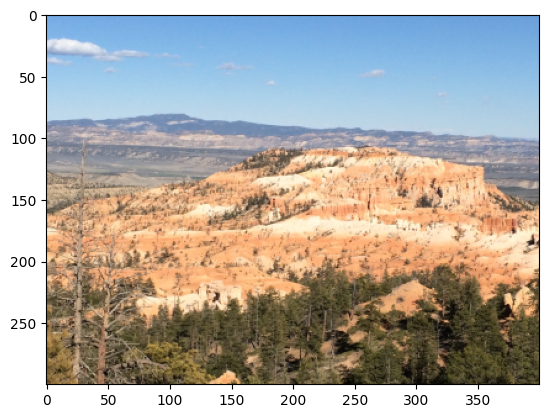

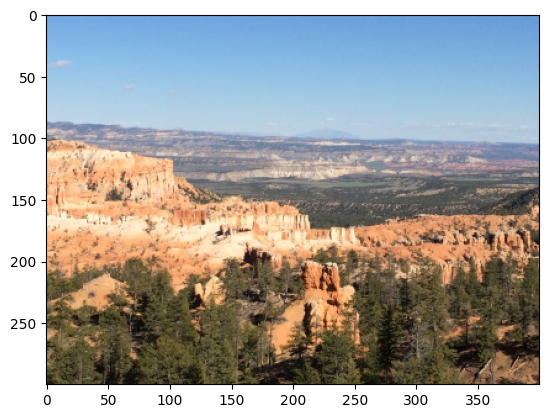

In [ ]:
import cv2

# Path to the images in Google Drive
image1_path = "/content/drive/MyDrive/Robot Bijak/SEM 5/Paronoma/SIFT-Panorama-Stitch-master/images/bryce_left_02.png"
image2_path = "/content/drive/MyDrive/Robot Bijak/SEM 5/Paronoma/SIFT-Panorama-Stitch-master/images/bryce_right_02.png"

# Load images
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

print("Original image dimension: " + str(image1.shape))

# We keep the images small to keep the computations short
image1 = imutils.resize(image1, width=400)
image2 = imutils.resize(image2, width=400)

print("Resized image dimension: " + str(image1.shape))

# OpenCV loads images in BGR format. Lets convert that to our RGB format that we are more comfortable with.
image1_RGB = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image1_RGB)
plt.show()

image2_RGB = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image2_RGB)
plt.show()

## 1. Detect Key Points

Now that we can see the images on our system as well, we should start with initializing a SIFT descriptor object. In openCV, we already have a default function that initializes the SIFT object. Using that SIFT object, we can compute the keypoints and their 128 dimensional features. After that, we convert the CV keypoint objects into numpy arrays for visualization and for further processing. Each sift keypoint has a 128 dimensional feature vector. In other works, each key point is described with 128 dimensional vector (Each keypoint is represented locally with its 4 x 4 neighbor blocks where each block is represented by 8 dimensional histograms, thus 4x4x8=128).See the lecture slides for further details.

| Difference of Gaussian    | SIFT Descriptor       |                
|:------------------------:|:-----------------------:|
| <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/figs/dog.PNG?raw=1" style="width:200px;height:150px;"> | <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/figs/descriptor.PNG?raw=1" style="width:300px;height:150px;"> |
| | [source](https://opencv-python-tutroals.readthedocs.io) |


**Functions:**
We will use the following functions that come under openCV in this exercise:
    
    cv2.xfeatures2d.SIFT_create()
    object.detectAndCompute(image, None)
    cv2.drawKeypoints(input_image, keypoints, output_image)

<div class="alert alert-info"><h1>Exercise 1</h1>
    <p> use OpenCV's sift computing function to compute the keypoints (<code>kps1</code> and <code>kps2</code>) and their descriptors (<code>features1</code> and <code>features2</code> ) for both images below. Then plot those keypoints on each image. </p>
</div>


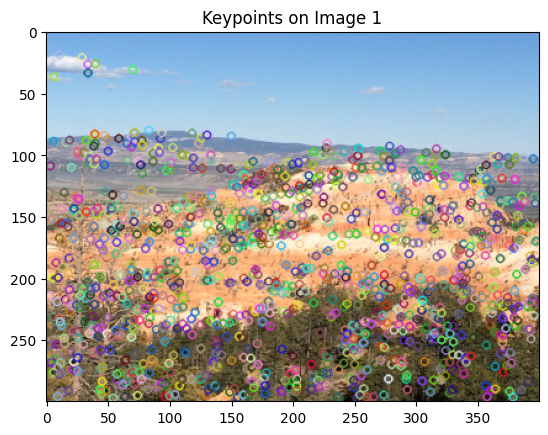

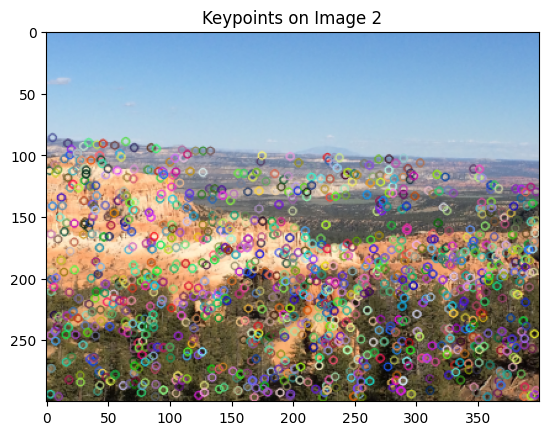

Feature descriptor length: 128
Keypoint length: 1225


In [ ]:
# Initialize DoG and SIFT
descriptor = cv2.xfeatures2d.SIFT_create()

# Extract features from each image
(kps1, features1) = descriptor.detectAndCompute(image1, None)
(kps2, features2) = descriptor.detectAndCompute(image2, None)

# Show the detected keypoints on both images
draw1 = image1.copy()
cv2.drawKeypoints(draw1, kps1, draw1)
draw1_RGB = cv2.cvtColor(draw1, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(draw1_RGB)
plt.title("Keypoints on Image 1")
plt.show()

draw2 = image2.copy()
cv2.drawKeypoints(draw2, kps2, draw2)
draw2_RGB = cv2.cvtColor(draw2, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(draw2_RGB)
plt.title("Keypoints on Image 2")
plt.show()

# Convert the keypoint types from OpenCV's KeyPoint objects to NumPy arrays
kps1 = np.float32([kp.pt for kp in kps1])
kps2 = np.float32([kp.pt for kp in kps2])

print("Feature descriptor length: " + str(features1.shape[1]))
print("Keypoint length: " + str(len(kps1)))

**Expected ouput:**

|Draw 1 | Draw 2 |             
|:------------------------:|:-----------------------:|
| <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/draw1.png?raw=1" style="width:200px;height:150px;"> | <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/draw2.png?raw=1" style="width:200px;height:150px;"> |

## 2. Matching Points

Now that we have keypoints and their descriptors for each image computed, we need to find the keypoint pairs that exist in both images. For that purpose, we initialize a object matcher with "Brute Force". This parameter ensures that each feature from image1 is compared to all the features from the second image. We then use the k-nearest neighbor algorithm, with k = 2, to find the top two matches for each points.

We then apply Lowe's ratio test to select matches where the best match is a ratio better than the second best.

**Functions:**

We will use the following functions that come under openCV in this exercise:
    
    cv2.DescriptorMatcher_create("BruteForce")
    object.knnMatch(features A, features B, k)
    
    
    
<div class="alert alert-info"><h1>Exercise 2</h1>
    <p> use openCV to compute the matching ke-ypoint pairs (<code>initialMatches</code>) between both images below. </p>
</div>



In [ ]:
# Initialize the brute-force matcher
matcher = cv2.DescriptorMatcher_create("BruteForce")

# Compute raw matches
initialMatches = matcher.knnMatch(features1, features2, 2)

# Initialize the list of actual matches
matches = []

# Lowe's ratio test
ratio = 0.75
for m in initialMatches:
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        matches.append((m[0].trainIdx, m[0].queryIdx))

# Convert the matches to NumPy array
matches = np.array(matches)

# Display the number of matches
print("Number of matches after Lowe's ratio test:", len(matches))

Number of matches after Lowe's ratio test: 264


Expected output: No output here!

## 3. Homography Matrix:

With our computed keypoint matches, we can now compute the Homography (H) matrix necessary to project one image onto the other. We will use RANSAC algorithm to compute the H matrix.

|[Source](https://docs.opencv.org/3.4.1/d9/dab/tutorial_homography.html) |          
|:------------------------:|
| <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/figs/homography.jpg?raw=1" style="width:500px;height:150px;"> |

**Functions:**

    cv2.findHomography(pointset1, pointset2, cv2.RANSAC, Ransac threshold)
    cv2.circle(image, points, radius, (B,G,R), thickness)





<div class="alert alert-info"><h1>Exercise 3</h1>
    <p> use openCV to compute Homography matrix H (<code>(H, status)</code>) by using the RANSAC algorithm. Then, plot only the matching keypoints on each image individually (<code>match1</code> and <code>match2</code>). </p>
</div>




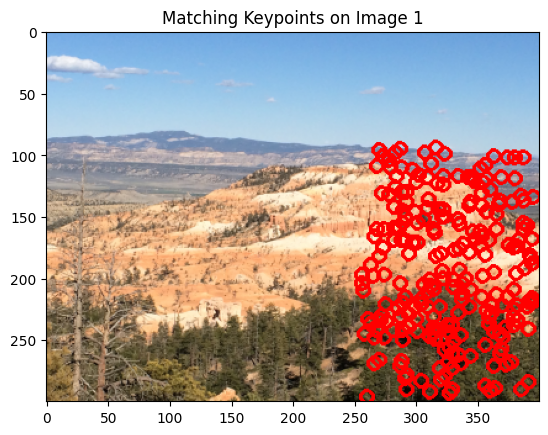

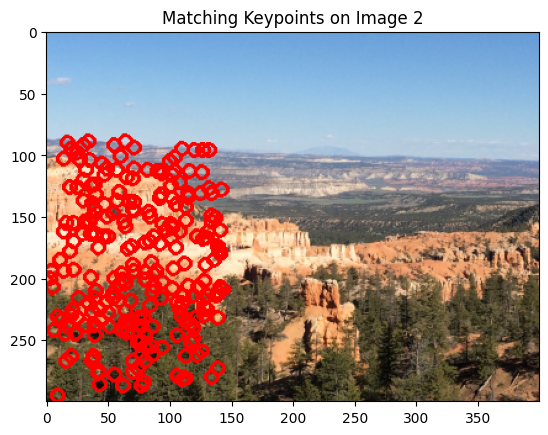

In [ ]:
# Check if there are at least 4 matches
if len(matches) > 4:
    # Construct the two sets of keypoints as np arrays
    ransacThresh = 4.0
    pts1 = np.float32([kps1[i] for (_, i) in matches])
    pts2 = np.float32([kps2[i] for (i, _) in matches])

    # Compute the homography between the two sets of points by using RANSAC
    (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransacThresh)

# Initialize match1 and match2
match1 = image1.copy()
match2 = image2.copy()

# Loop over the matches
for ((trainIdx, queryIdx), s) in zip(matches, status):
    # Only process the match if the keypoint was successfully matched
    if s == 1:
        # Draw the match
        pt1 = (int(kps1[queryIdx][0]), int(kps1[queryIdx][1]))
        pt2 = (int(kps2[trainIdx][0]), int(kps2[trainIdx][1]))

        # Draw circles around matching keypoints (use red color)
        cv2.circle(match1, pt1, 5, (0, 0, 255), 2)
        cv2.circle(match2, pt2, 5, (0, 0, 255), 2)

# Convert images to RGB for plotting
match1_RGB = cv2.cvtColor(match1, cv2.COLOR_BGR2RGB)
match2_RGB = cv2.cvtColor(match2, cv2.COLOR_BGR2RGB)

# Plot matching keypoints on Image 1
plt.figure()
plt.imshow(match1_RGB)
plt.title("Matching Keypoints on Image 1")
plt.show()

# Plot matching keypoints on Image 2
plt.figure()
plt.imshow(match2_RGB)
plt.title("Matching Keypoints on Image 2")
plt.show()


**Expected ouput:**

|Draw 1 | Draw 2 |             
|:------------------------:|:-----------------------:|
| <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/match1.png?raw=1" style="width:200px;height:150px;"> | <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/match2.png?raw=1" style="width:200px;height:150px;"> |



## Visualization of only the matching key-points

Now that we know what the stiched image looks like, lets have a look at what features matched in both images. For, that, we will visualize the matching features on both images shown side by side. For that we will pick all the matching key point-pairs and visualize them pair by pair as a line. In this way, the left side of the image will show the first image, and the right hand side will show the second image. Since we need two points to draw a line, all we need is actually those individual matching pairs to draw matching lines. See the expected results below. You should see mostly parallel lines.

**Functions:**

    cv2.line(image, point 1, point 2, (0, 255, 0), thicknessVal)
    



<div class="alert alert-info"><h1>Exercise 4</h1>
    <p> use openCV to plot the new image containing the matching keypoints only  (<code>initialMatches</code>) between both images below. </p>
</div>




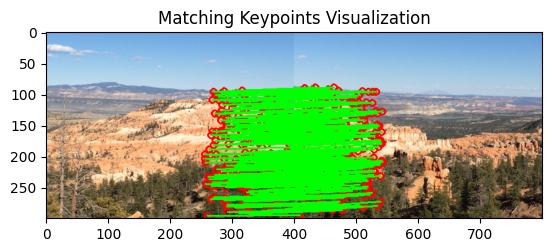

In [ ]:
# Initialize the output visualization image
(h1, w1) = image1.shape[:2]
(h2, w2) = image2.shape[:2]
vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")
vis[0:h1, 0:w1] = match1
vis[0:h2, w1:] = match2

# Loop over the matches
for ((trainIdx, queryIdx), s) in zip(matches, status):
    # Only process the match if the keypoint was successfully matched
    if s == 1:
        # Draw the match
        pt1 = (int(kps1[queryIdx][0]), int(kps1[queryIdx][1]))
        pt2 = (int(kps2[trainIdx][0]) + w1, int(kps2[trainIdx][1]))

        # Use the color green for lines
        cv2.line(vis, pt1, pt2, (0, 255, 0), 2)

vis_RGB = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(vis_RGB)
plt.title("Matching Keypoints Visualization")
plt.show()


**Expected ouput:**

|Draw 1 |          
|:------------------------:|
| <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/vis.png?raw=1" style="width:400px;height:150px;"> |




## 4. Warp and Stitch

Finally after computing the homography matrix, we warp the second image (called image1) on to the first one (called image2). Meanwhile, we also ensure that the size of the final (stiched) image can fit the both images to be stiched.

**Functions:** You can use openCV's built-in function warpPerspective here (see below).

    cv2.warpPerspective(image2, HomographyMatrix,(image2_width + image1_width, image2_height))
    


<div class="alert alert-info"><h1>Exercise 5</h1>
    <p> Given the computed H matrix and both images, use openCV to stitch both images into a single image  by projecting one image onto the other one and obtain the final stiched image (<code>result</code>) below. </p>
</div>





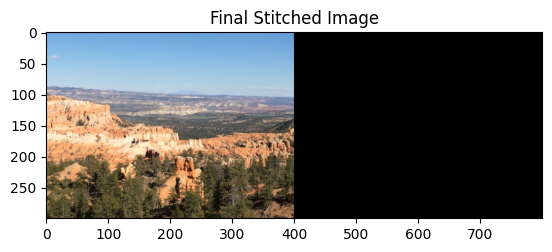

In [ ]:
# Check if there are at least 4 matches
if len(matches) > 4:
    # Construct the two sets of keypoints as np arrays
    ransacThresh = 4.0
    pts1 = np.float32([kps1[i] for (_, i) in matches])
    pts2 = np.float32([kps2[i] for (i, _) in matches])

    # Compute the homography between the two sets of points by using RANSAC
    (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransacThresh)

    # Use the homography matrix to warp image1 onto a canvas
    result = cv2.warpPerspective(image1, H, (image2.shape[1] + image1.shape[1], image2.shape[0]))

    # Copy the content of image2 onto the result image
    result[0:image2.shape[0], 0:image2.shape[1]] = image2

# Visualize the final stitched image
result_RGB = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(result_RGB)
plt.title("Final Stitched Image")
plt.show()


**Expected ouput:**

|Draw 1 |          
|:------------------------:|
| <img src="https://github.com/Rice-Field/SIFT-Panorama-Stitch/blob/master/images/result.png?raw=1" style="width:400px;height:150px;"> |

Congratulations! You now know how to compute SIFT features, how to match them and how to stich images! You also practiced how to compute the homogprahy matrix by using RANSAC now.